In [1]:
def plot_n_images(title_image_map, cmap=None):
    cols = 2
    import math
    rows = math.ceil(len(title_image_map) / cols)
    if rows < 1:
        rows = 1

    f, axes = plt.subplots(rows, cols, figsize=(24, 9), squeeze=False)
    #f.tight_layout()
    axes = axes.flatten()
    i = 0
    for title, image in title_image_map.items():
        if cmap == None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image, cmap=cmap)
        axes[i].set_title(title, fontsize=40)
        i = i + 1
        
    plt.subplots_adjust(left=0., right=1, top=2.5, bottom=1.0)

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

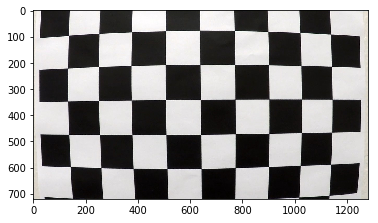

In [3]:
test_image = mpimg.imread("./camera_cal/calibration1.jpg")
plt.imshow(test_image)

In [4]:
object_points = []
image_points = []
nx=9
ny=6
visualize=False
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

import glob
for image_path in glob.glob("./camera_cal/*.jpg"):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_image, (nx, ny), None)

    if ret == True:
        object_points.append(np.copy(objp))
        image_points.append(corners)

        if visualize: 
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            cv2.imshow("image", image)
            cv2.waitKey(500)
if visualize:
    cv2.destroyAllWindows()
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, test_image.shape[::-2],None,None)
cv2.undistort(test_image, mtx, dist, None, mtx)
            
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)
    
def unwarp(image, src, dst):
    h, w = image.shape[:2]

    undistorted_image = undistort(image)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(undistorted_image, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

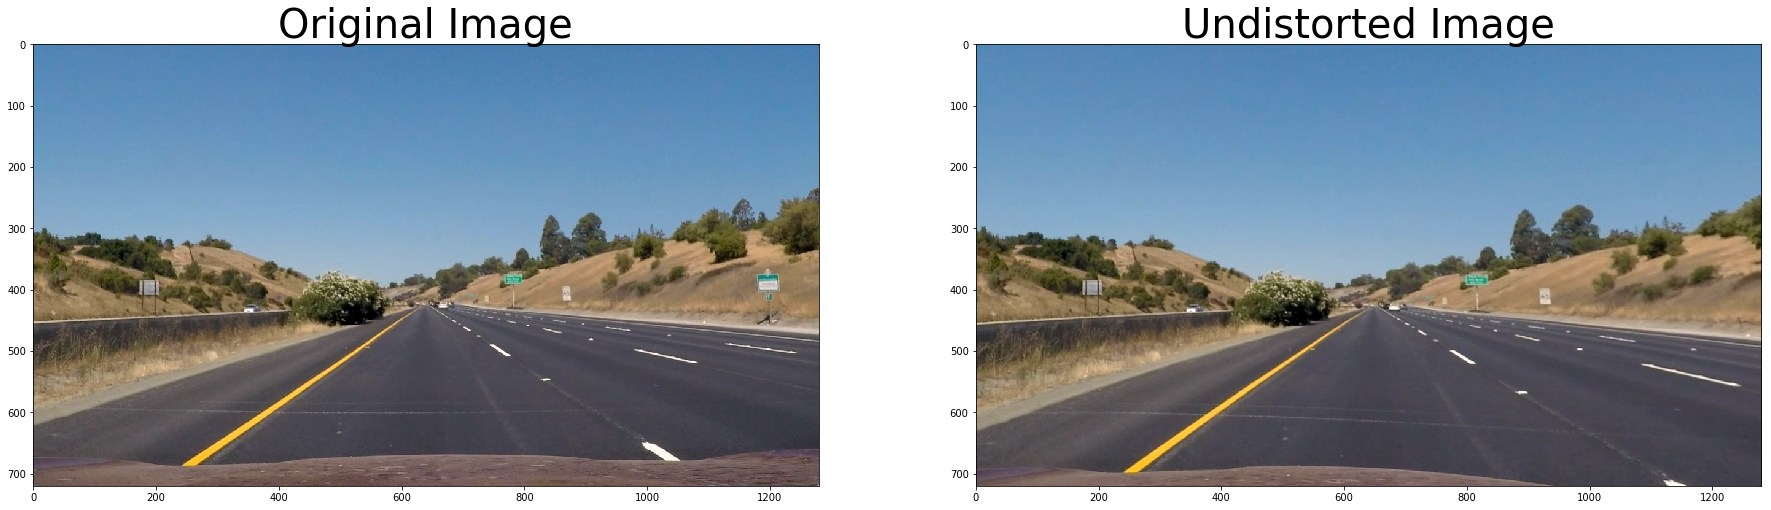

In [6]:
lane_image = cv2.imread("./test_images/straight_lines1.jpg")
undistort_map = {}
undistort_map['Original Image'] = lane_image
undistort_map["Undistorted Image"] = undistort(lane_image)
plot_n_images(undistort_map)

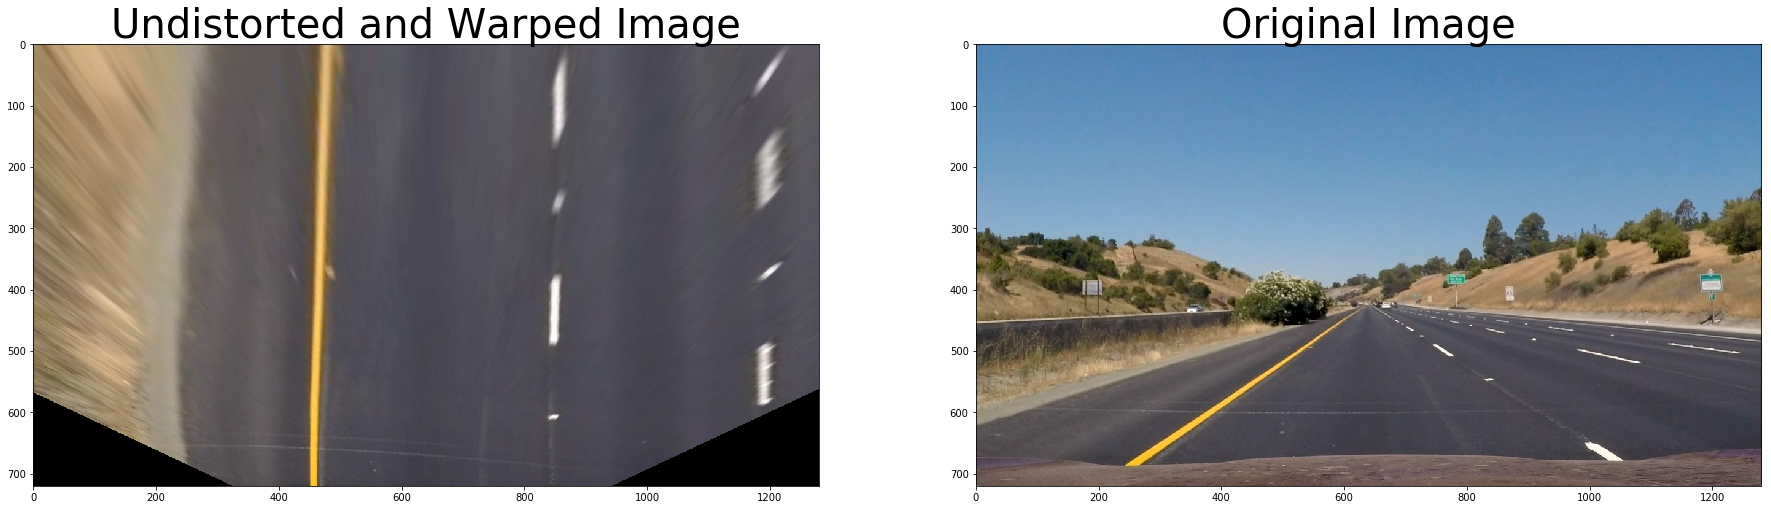

In [7]:
h,w = undistort_map["Undistorted Image"].shape[:2]
# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

warped_map = {}
warped_map['Original Image'] = lane_image
top_down, _, _ = unwarp(lane_image, src, dst)
warped_map['Undistorted and Warped Image'] = top_down
plot_n_images(warped_map)

In [8]:
def apply_threshold(image, threshold):
    """ Normalizes an image and returns the binary image with the values in the range of the threshold"""
    image = np.uint8(255 * image / np.max(image))
        
    binary_image = np.zeros_like(image)
    binary_image[(image >= threshold[0]) & (image <= threshold[1])] = 1
    
    return binary_image

In [9]:
def apply_sobel(image, orient = 'x', sobel_kernel = 3, threshold = (20, 100)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    return apply_threshold(abs_sobel, threshold)

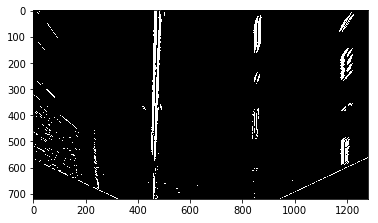

In [16]:
plt.imshow(apply_sobel(top_down), cmap='gray')

In [18]:
def magnitude_threshold(image, sobel_kernel=3, threshold=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
   
    return apply_threshold(gradient_magnitude, threshold)

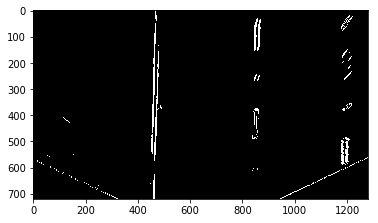

In [21]:
plt.imshow(magnitude_threshold(top_down, 9, (50, 110)), cmap='gray')

In [22]:
def direction_threshold(image, sobel_kernel=3, threshold=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= threshold[0]) & (direction <= threshold[1])] = 1

    return binary_output

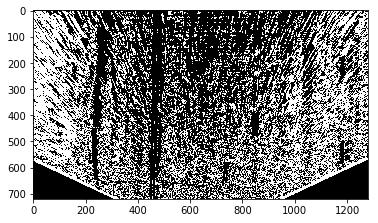

In [25]:
plt.imshow(direction_threshold(top_down, 11, (0.5, 1.3)), cmap='gray')

In [26]:
def combined_threshold(image, ksize = 3):
    # Apply each of the thresholding functions
    gradx = apply_sobel(image, orient='x', sobel_kernel=ksize, threshold=(100, 160))
    grady = apply_sobel(image, orient='y', sobel_kernel=ksize, threshold=(100, 160))
    mag_binary = magnitude_threshold(image, sobel_kernel=ksize, threshold=(100, 160))
    dir_binary = direction_threshold(image, sobel_kernel=ksize, threshold=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | (mag_binary == 1)] = 1

    return combined

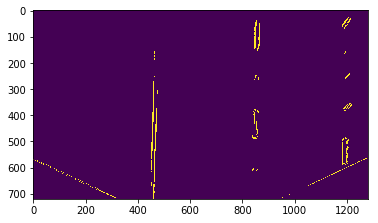

In [28]:
plt.imshow(combined_threshold(top_down, 19))

In [33]:
def channel_threshold(work_image, threshold, selected_channel):
    binary_selected = np.zeros_like(work_image[:,:,selected_channel])
    binary_selected[(work_image[:,:,selected_channel] > threshold[0]) & 
                    (work_image[:,:,selected_channel] <= threshold[1])] = 1
    
    return binary_selected

def inspect_color_space(image, threshold, conversion=None, selected_channel=0):
    dict_normal = {}
    dict_binary = {}
    if conversion != None:
        work_image = cv2.cvtColor(image, conversion)
    else:
        work_image = np.copy(image)
    
    dict_normal["Original"]  = work_image
    dict_normal["Channel 0"] = work_image[:,:,0]
    dict_normal["Channel 1"] = work_image[:,:,1]
    dict_normal["Channel 2"] = work_image[:,:,2]
    
    gray = cv2.cvtColor(work_image, cv2.COLOR_RGB2GRAY)
    binary_orig = np.zeros_like(gray)
    binary_orig[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    
    binary_selected = channel_threshold(work_image, threshold, selected_channel)
    
    dict_binary["Binary Original"] = binary_orig
    dict_binary["Binary Selected"] = binary_selected
    
    plot_n_images(dict_normal, "gray")
    plot_n_images(dict_binary, "gray")
    
    return binary_selected

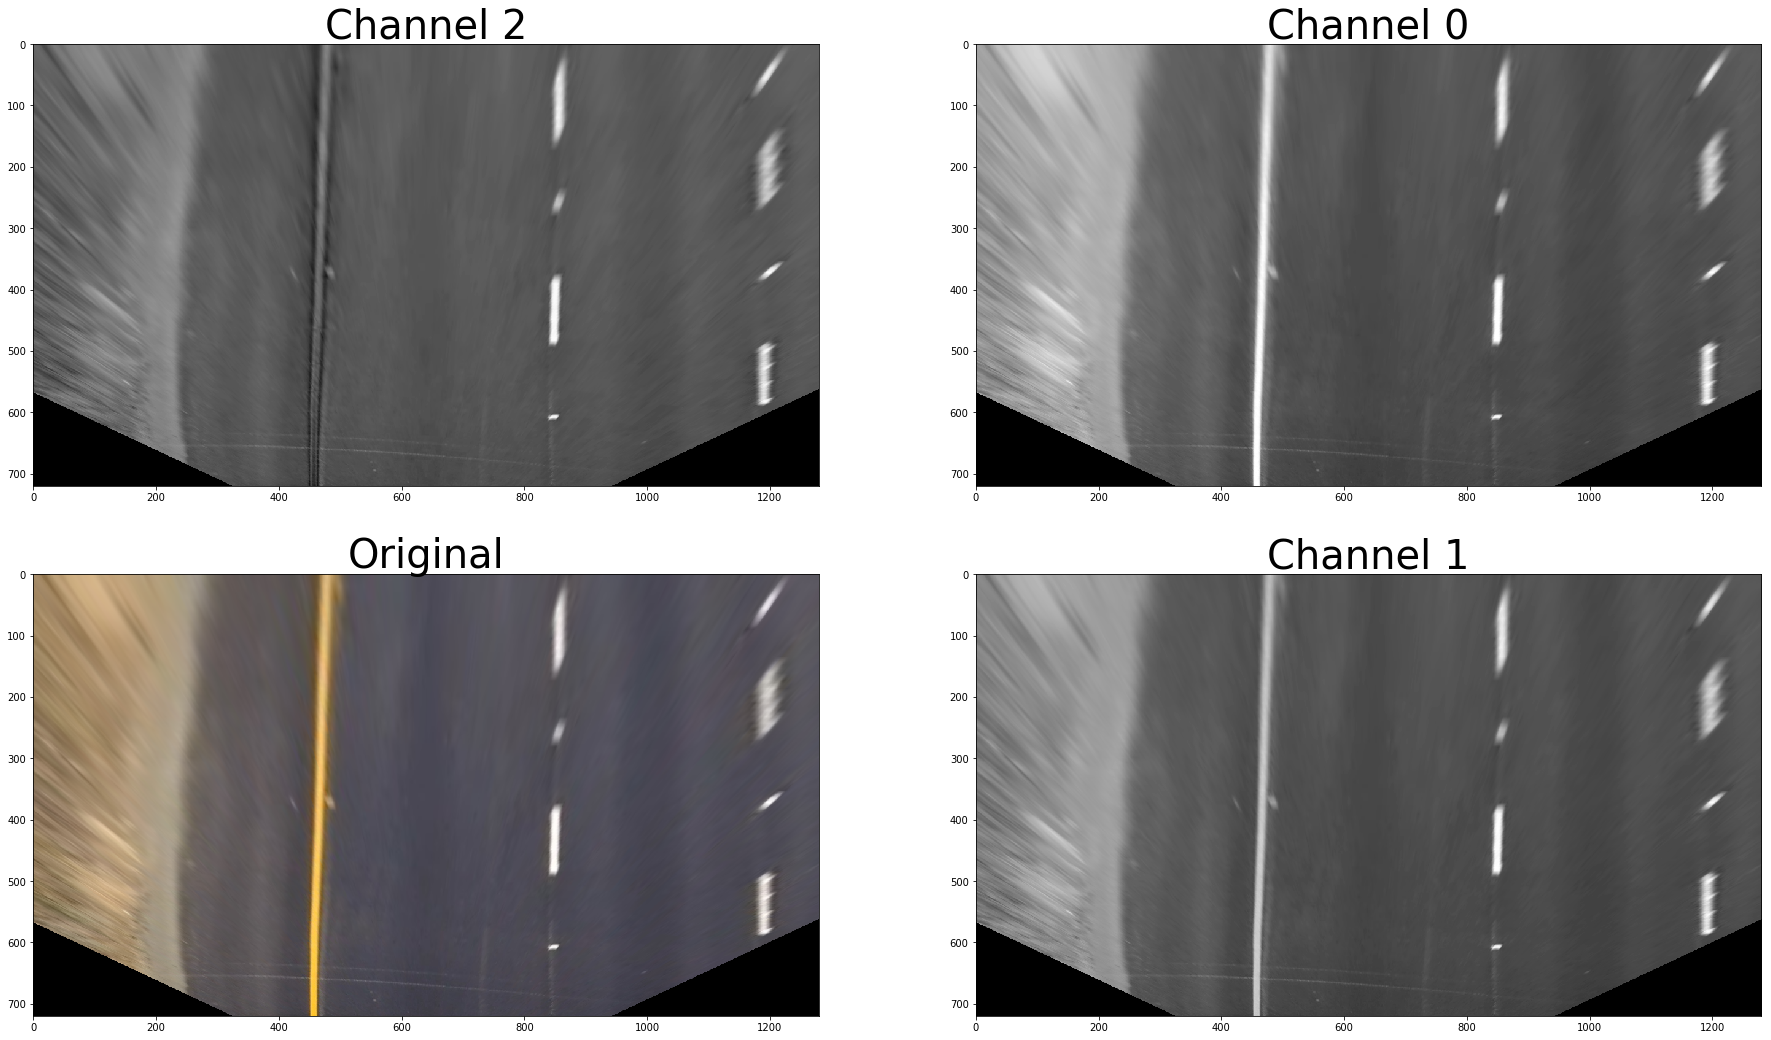

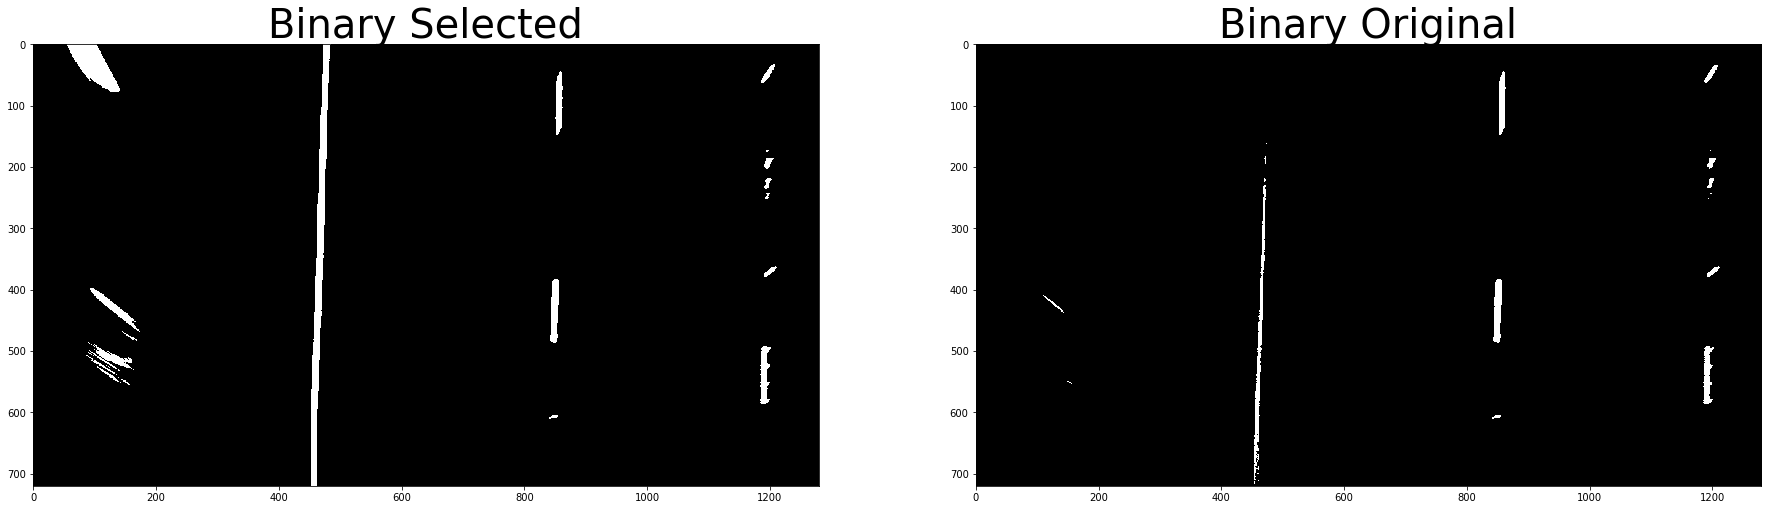

In [34]:
binary_r = inspect_color_space(top_down, threshold=(200, 255), conversion=cv2.COLOR_BGR2RGB)

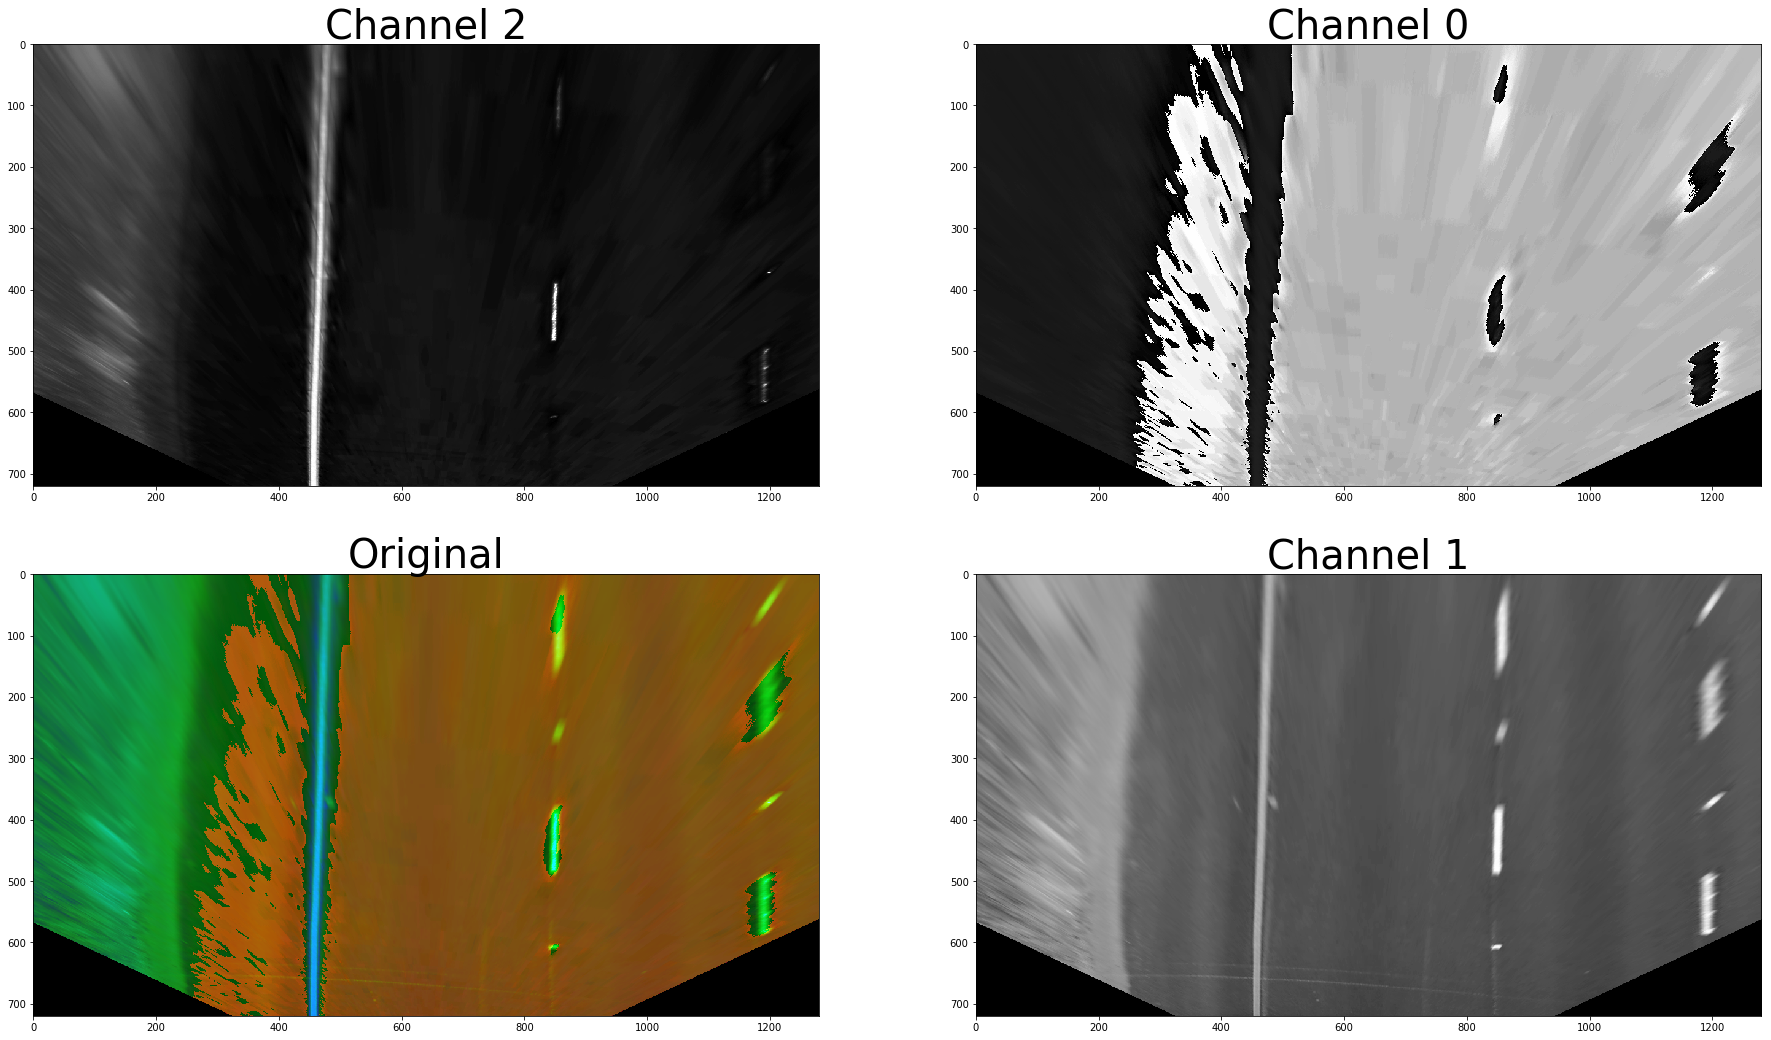

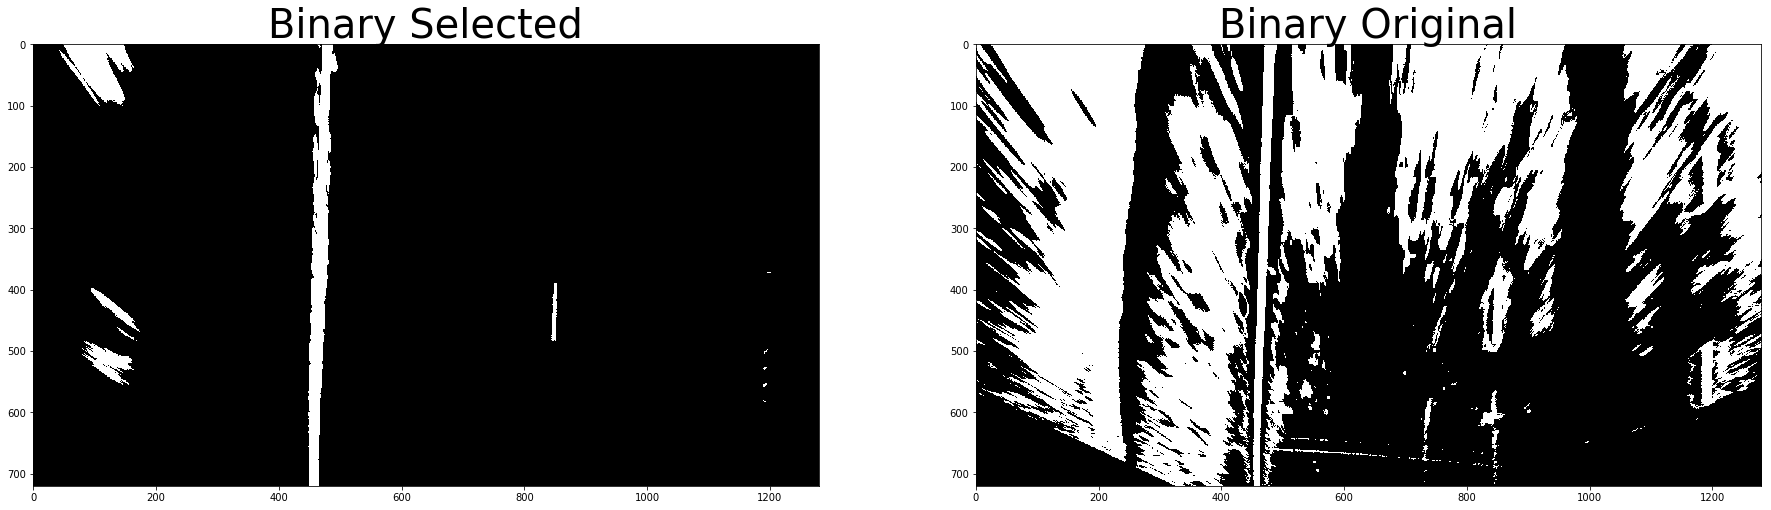

In [35]:
binary_s = inspect_color_space(warped_map['Undistorted and Warped Image'], threshold=(90, 255), conversion=cv2.COLOR_BGR2HLS, selected_channel=2)

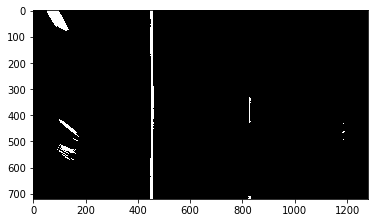

In [63]:
combined = np.zeros_like(binary_r)
combined[(binary_r == 1) & (binary_s == 1)] = 1
plt.imshow(combined, cmap='gray')

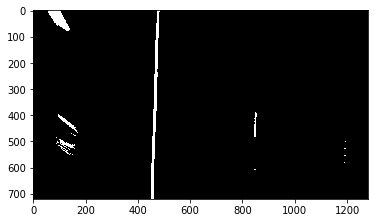

In [64]:
def image_pipeline(image):
    top_down, _, _ = unwarp(image, src, dst)
    binary_r = channel_threshold(top_down, (200, 255), 2)
    binary_s = channel_threshold(cv2.cvtColor(top_down, cv2.COLOR_BGR2HLS), (90, 255), 2)
    
    combined = np.zeros_like(binary_r)
    combined[(binary_r == 1) & (binary_s == 1)] = 1
    
    return combined

plt.imshow(image_pipeline(lane_image), cmap='gray')

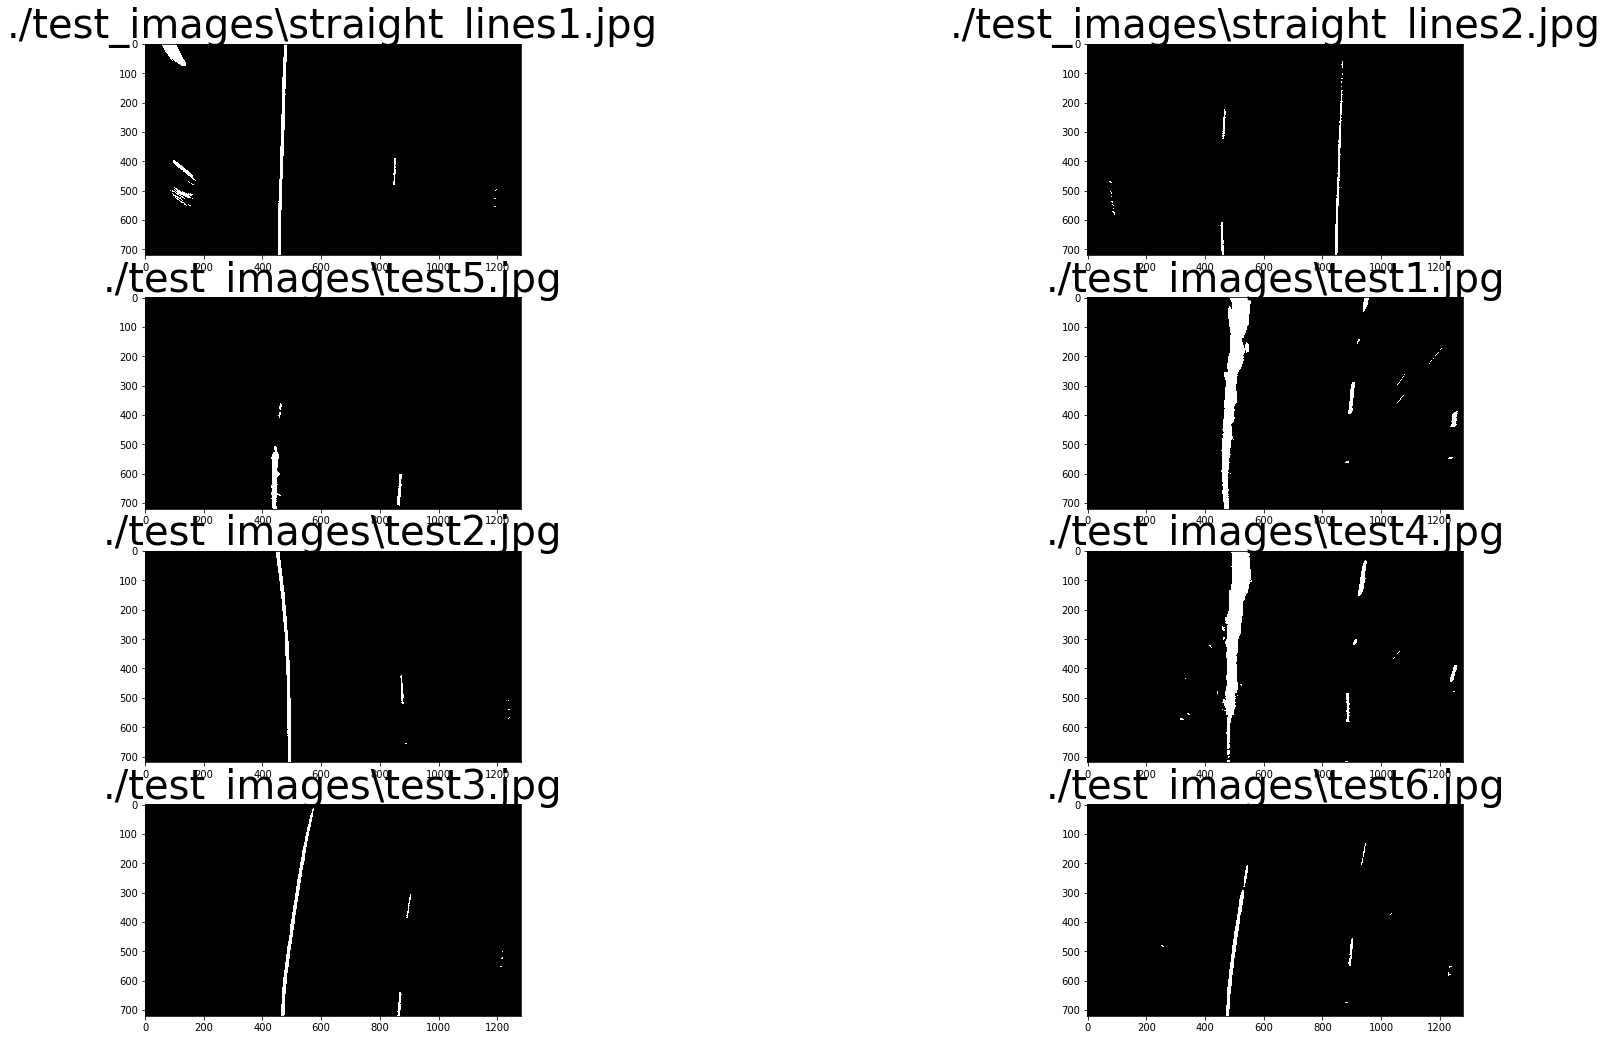

In [68]:
images = glob.glob('./test_images/*.jpg')

images_dict = {}
for image_path in images:
    image = cv2.imread(image_path)
    images_dict[image_path] = image_pipeline(image)

plot_n_images(images_dict, "gray")